In [1]:
from Bio import Nexus, Phylo, SeqIO
from collections import defaultdict
from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import re
from pathlib import Path

from itertools import combinations
from evaluation_helpers import *

# Evaluate estimation of population size with skyline / constant coalescent prior in BEAST

In [2]:
input_csv = "../scripts/successful_mcmc_runs.csv" 
df = process_results(input_csv)
df.head()

,population_model,mutation_signal,tree_index,sim_tree_path,present_pop_size,growth_rate,log_path_constcoal,log_path_skyline,tree_path_constcoal,tree_path_skyline
0,expgrowth_fast,high,0,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
1,expgrowth_fast,high,1,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
2,expgrowth_fast,high,2,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
3,expgrowth_fast,high,3,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
4,expgrowth_fast,high,4,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...


In [4]:
log_test_path = "/Users/mariebecker/Documents/Uni/ETH/RotationStadler/BESP_paper-analyses/scripts/../results/pop_size_simulations/simulation_results/homochronous_independent/skyline/expgrowth_fast/highmutsig/skyline_homochronous_expgrowth_fast_highmutsig.T0.log"
log_test_path_coal = "/Users/mariebecker/Documents/Uni/ETH/RotationStadler/BESP_paper-analyses/scripts/../results/pop_size_simulations/simulation_results/homochronous_independent/constcoal/expgrowth_fast/highmutsig/constcoal_homochronous_expgrowth_fast_highmutsig.T0.log"
get_mean_population_size(log_test_path, burnin=0.1, mode="skyline")

array([1951.39428927, 1149.0680481 , 1704.29154715, 2786.18455679,
       1010.61665379, 1492.07751337, 2190.51508187, 1435.58426398,
       1620.29171021, 1028.89520031])

In [5]:
tree_test_path = "/Users/mariebecker/Documents/Uni/ETH/RotationStadler/BESP_paper-analyses/scripts/../results/pop_size_simulations/simulation_results/homochronous_independent/skyline/expgrowth_fast/highmutsig/skyline_homochronous_expgrowth_fast_highmutsig.T0.tree"
tree_test = Phylo.read(tree_test_path, "nexus")

In [6]:
get_skyline_group_boundaries(tree_test, num_groups=10)

[1.8023924367337258,
 2.8553478496705793,
 5.293366711234512,
 11.237468572885973,
 13.74708957059238,
 20.042943983278747,
 34.57744033936456,
 55.582654107238454,
 120.48616342747562,
 763.8784242754721]

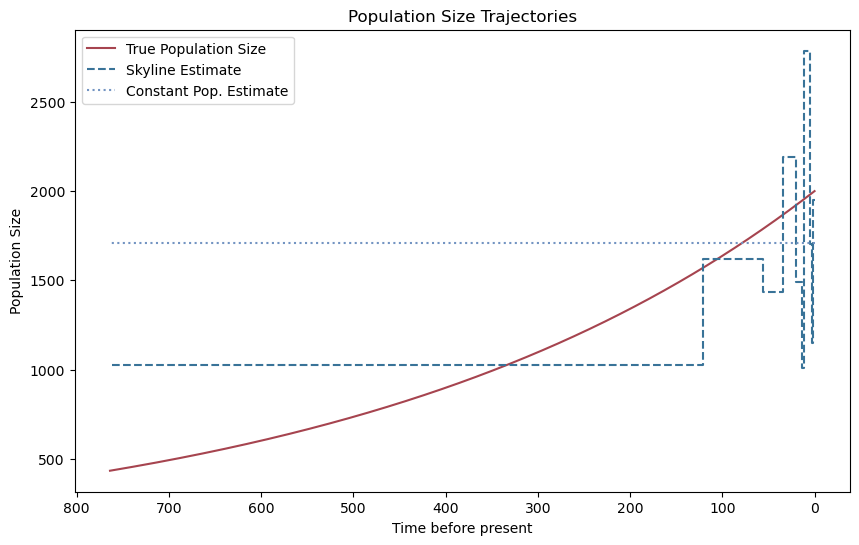

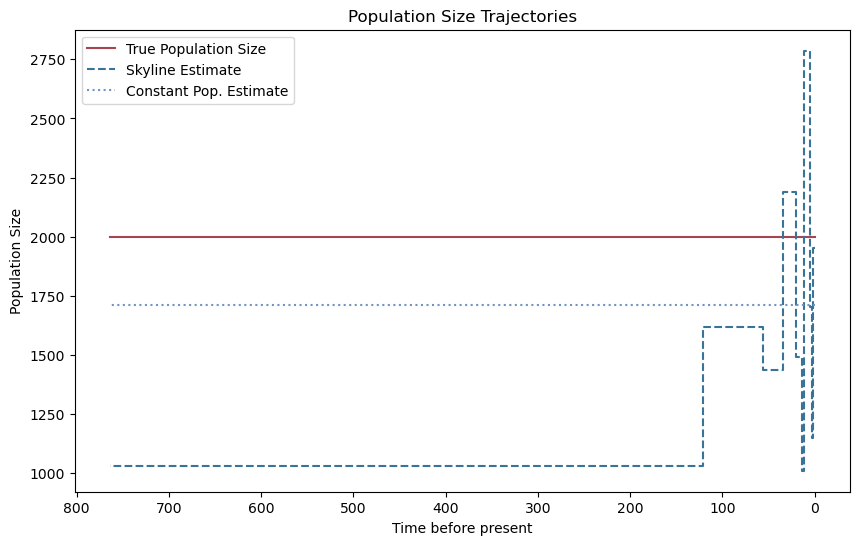

In [7]:
def plot_population_trajectories(skyline_times, skyline_means, constant_pop_estimate, present_pop_size, growth_rate = None):
    """
    Plots:
    - Exponential population growth (true)
    - Stepwise skyline population size estimates
    - Constant population estimate (overall mean)
    
    Parameters:
        skyline_times (list): End time points of skyline intervals (backward in time, ascending).
        skyline_means (list): Mean population sizes for each interval.
        present_pop_size (float): True present-day population size (N0).
        growth_rate (float): Exponential growth rate (r).
        constant_pop_estimate (float): Overall mean population size.
    """
    root_height = skyline_times[-1]  # The last time point is the root height (earliest time)

    # True exponential function (from root to present, i.e., from T to 0)
    t_vals = np.linspace(0, root_height, 1000)
    N_true = present_pop_size * np.exp(-growth_rate * t_vals)

    # Stepwise skyline values
    skyline_start_times = [0.0] + skyline_times[:-1]
    skyline_end_times = skyline_times
    step_times = []
    step_values = []

    for start, end, value in zip(skyline_start_times, skyline_end_times, skyline_means):
        step_times.extend([start, end])
        step_values.extend([value, value])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(t_vals, N_true, label="True Population Size", color = '#a6444f')
    plt.plot(step_times, step_values, drawstyle='steps-post', label="Skyline Estimate", linestyle = "--", color = "#397398")
    plt.hlines(constant_pop_estimate, 0, root_height, color='#7394c2', linestyle=':', label="Constant Pop. Estimate")

    plt.xlabel("Time before present")
    plt.ylabel("Population Size")
    plt.title("Population Size Trajectories")
    plt.legend()
    plt.gca().invert_xaxis()  # show present (0) on the right
    plt.show()


skyline_times = get_skyline_group_boundaries(tree_test, num_groups=10)
skyline_means = get_mean_population_size(log_test_path, burnin=0.1, mode="skyline")
coalescent_mean = get_mean_population_size(log_test_path_coal, burnin=0.1, mode="constcoal")

plot_population_trajectories(skyline_times, skyline_means, 
                             present_pop_size=2000, growth_rate=0.002, 
                             constant_pop_estimate=coalescent_mean)

plot_population_trajectories(skyline_times, skyline_means, 
                             present_pop_size=2000, growth_rate=0, 
                             constant_pop_estimate=coalescent_mean)


In [8]:
df_ = df.dropna()

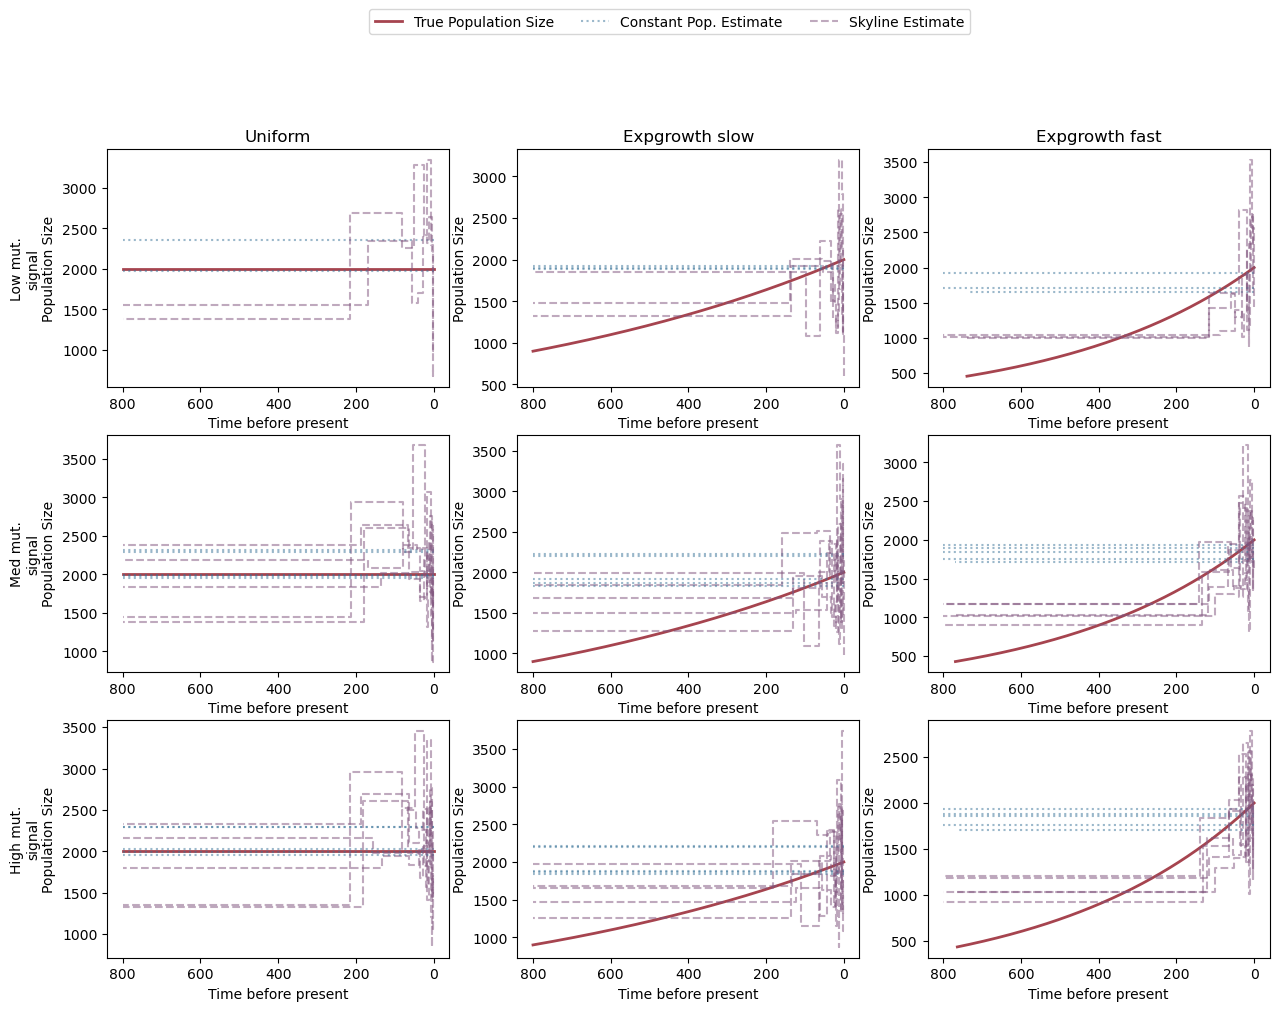

In [9]:
plot_summary_population_grid(df_, time_horizon=800)

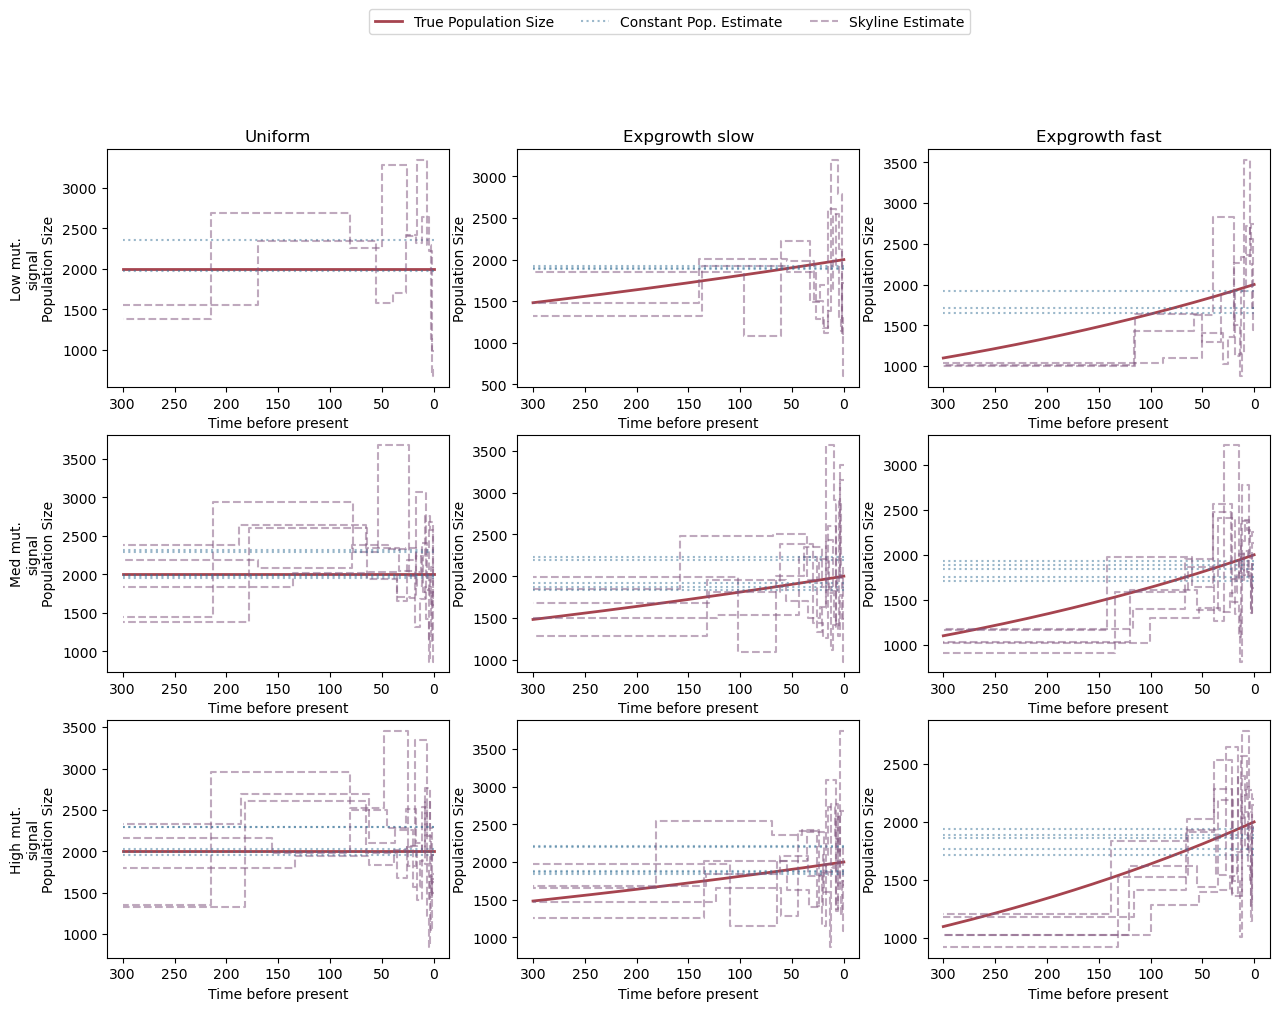

In [12]:
plot_summary_population_grid(df_, time_horizon=300)

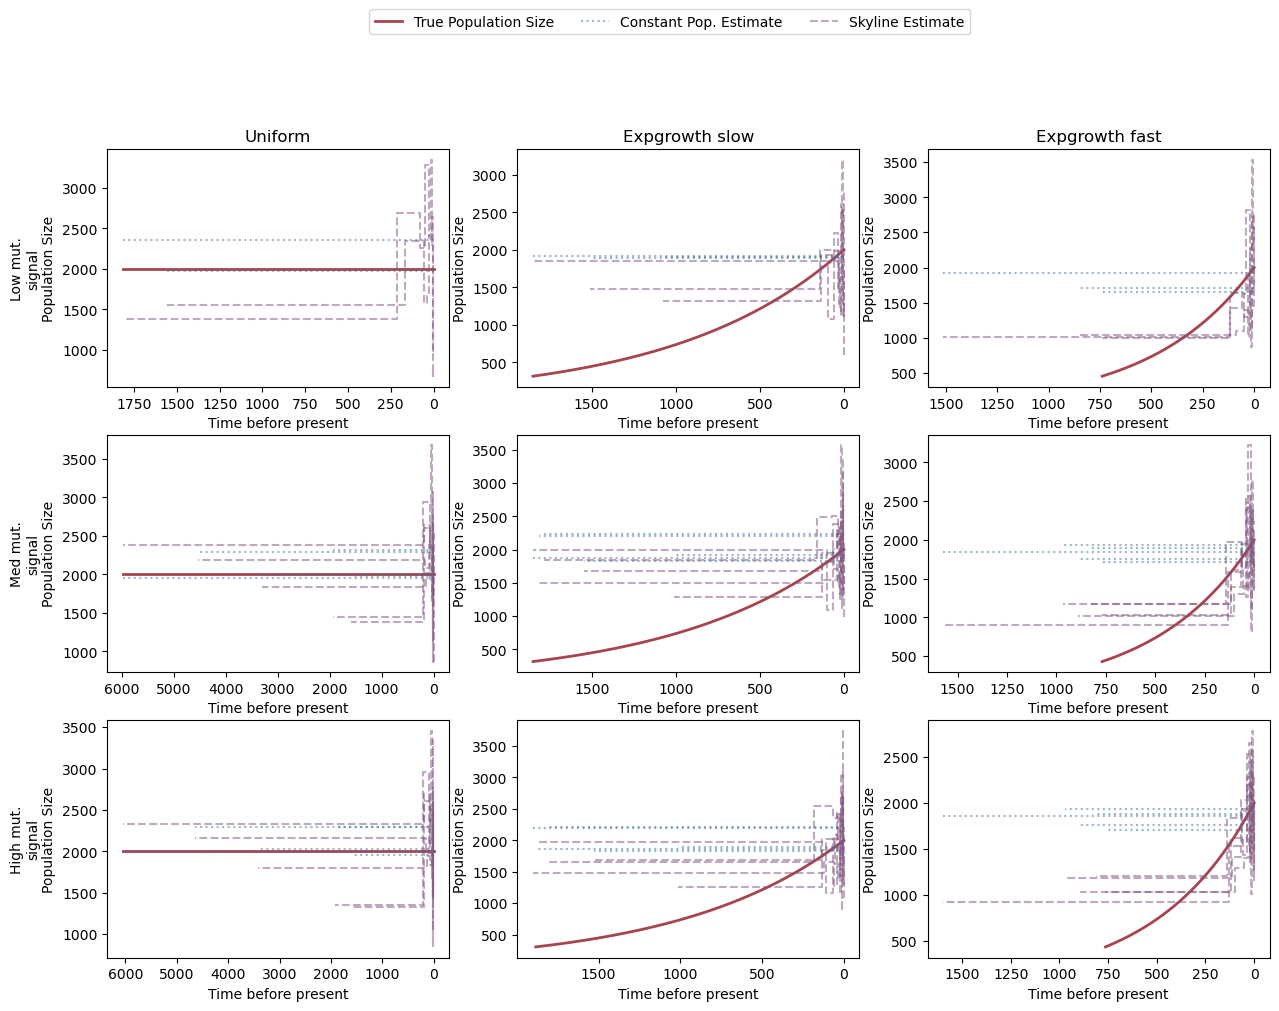

In [11]:
plot_summary_population_grid(df_, time_horizon=0)

## Evaluate error in population size

In [15]:
df_

,population_model,mutation_signal,tree_index,sim_tree_path,present_pop_size,growth_rate,log_path_constcoal,log_path_skyline,tree_path_constcoal,tree_path_skyline
0,expgrowth_fast,high,0,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
1,expgrowth_fast,high,1,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
2,expgrowth_fast,high,2,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
3,expgrowth_fast,high,3,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
4,expgrowth_fast,high,4,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
5,expgrowth_fast,low,0,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
8,expgrowth_fast,low,3,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
9,expgrowth_fast,low,4,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
10,expgrowth_fast,med,0,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
11,expgrowth_fast,med,1,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...


In [18]:
df_complete = add_tree_information(df_)      
df_complete.head()   

,population_model,mutation_signal,tree_index,sim_tree_path,present_pop_size,growth_rate,log_path_constcoal,log_path_skyline,tree_path_constcoal,tree_path_skyline,skyline_means,skyline_times,coalescent_mean
0,expgrowth_fast,high,0,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1951.3942892726484, 1149.0680481003405, 1704....","[1.8023924367337258, 2.8553478496705793, 5.293...",1710.872499
1,expgrowth_fast,high,1,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[2195.7443013891184, 2276.5029658333433, 2299....","[2.0457589295967864, 4.764664902355776, 7.8819...",1939.366430
2,expgrowth_fast,high,2,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1920.9790953702218, 1271.0700522226946, 1958....","[1.924766352503525, 2.917556396694067, 6.32949...",1885.024770
3,expgrowth_fast,high,3,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[2148.504874426889, 1497.9425407533827, 1620.8...","[1.9803686778427618, 3.656818205781292, 5.5356...",1860.562984
4,expgrowth_fast,high,4,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1953.4474028920622, 2081.4437204744463, 2195....","[1.7185173137743277, 4.0100807028806, 7.322278...",1765.282609


In [14]:
# TODO: Plot error in Node height / Branch length against error in population size
# TODO:Write a function that takes as input a time point and outputs error in population size at this position


def calculate_population_size_error(
    t,
    present_pop_size,
    growth_rate,
    skyline_times=None,
    skyline_means=None,
    coalescent_mean=None
):
    # 1. True population size at time t
    true_pop_size = present_pop_size * np.exp(growth_rate * t)

    # 2. Estimated population size
    if coalescent_mean is not None:
        est_pop_size = coalescent_mean

    elif skyline_times is not None and skyline_means is not None:

        # Use np.searchsorted to find the correct interval index
        interval_index = np.searchsorted(skyline_times, t, side="right")
        est_pop_size = skyline_means[interval_index]

    else:
        raise ValueError("Either coalescent_mean or skyline_times + skyline_means must be provided.")

    # 3. Compute errors
    relative_error = (est_pop_size - true_pop_size) / true_pop_size
    abs_relative_error = abs(relative_error)

    return {
        "true_pop_size": true_pop_size,
        "est_pop_size": est_pop_size,
        "relative_error": relative_error,
        "abs_relative_error": abs_relative_error
    }
   

In [ ]:
def plot_population_trajectories_ax(ax, skyline_times, skyline_means, constant_pop_estimate, 
                                     present_pop_size, growth_rate=None,
                                     color_exp="#a6444f", color_sky="#80557e", color_const="#397398",
                                     alpha=0.4, label_prefix="", first_plot=True, time_horizon=0):

    root_height = skyline_times[-1]
    t_max = root_height if time_horizon == 0 else min(time_horizon, root_height)
    t_vals = np.linspace(0, t_max, 1000)
    N_true = present_pop_size * np.exp(-growth_rate * t_vals)

    # Stepwise skyline
    skyline_start_times = [0.0] + skyline_times[:-1]
    step_times, step_values = [], []
    for start, end, value in zip(skyline_start_times, skyline_times, skyline_means):
        if start > t_max:
            break
        end = min(end, t_max)
        step_times.extend([start, end])
        step_values.extend([value, value])
    
    if first_plot:
        ax.plot(t_vals, N_true, color=color_exp, alpha=1, linewidth= 2, label="True Population Size")
        ax.hlines(constant_pop_estimate, 0, t_max, color=color_const, linestyle=':', 
              alpha=alpha)
        ax.plot(step_times, step_values, drawstyle='steps-post', linestyle='--', color=color_sky, 
            alpha=alpha)
    else:
        ax.hlines(constant_pop_estimate, 0, t_max, color=color_const, linestyle=':', 
              alpha=alpha, label="Constant Pop. Estimate")
        ax.plot(step_times, step_values, drawstyle='steps-post', linestyle='--', color=color_sky, 
            alpha=alpha, label="Skyline Estimate")

    if first_plot:
        ax.set_xlabel("Time before present")
        ax.set_ylabel("Population Size")
        ax.invert_xaxis()
        
def plot_summary_population_grid(path_info_df, num_groups=10, burnin=0.1, time_horizon = 0):
    """
    Plots all population trajectories for all trees in a subplot grid by
    population model (columns) and mutation signal (rows).
    
    Parameters:
        path_info_df (pd.DataFrame): Table with tree/log paths and metadata.
        present_pop_size (float): N0
        growth_rate (float): Exponential growth rate
        num_groups (int): Number of skyline intervals
        burnin (float or int): Burnin for BEAST logs
    """
    pop_models = ["uniform", "expgrowth_slow", "expgrowth_fast"]
    mut_signals = ["low", "med", "high"]
    ncols, nrows = len(pop_models), len(mut_signals)

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3.5*nrows))

    # Ensure axes is always 2D array
    if nrows == 1:
        axes = np.expand_dims(axes, axis=0)
    if ncols == 1:
        axes = np.expand_dims(axes, axis=1)

    first_plot = True
    previous_tree_index = 0

    for idx, row in path_info_df.iterrows():
        
        tree_path_constcoal = row["tree_path_constcoal"]
        tree_path_skyline = row["tree_path_skyline"]
        log_path_constcoal = row["log_path_constcoal"]
        log_path_skyline = row["log_path_skyline"]
        pop_model = row["population_model"]
        mut_sig = row["mutation_signal"]
        present_pop_size = row["present_pop_size"]
        growth_rate = row["growth_rate"]
        tree_index = row["tree_index"]


        row_idx = mut_signals.index(mut_sig)
        col_idx = pop_models.index(pop_model)
        ax = axes[row_idx][col_idx]

        # Parse data
        tree = Phylo.read(tree_path_skyline, "nexus")
        skyline_times = get_skyline_group_boundaries(tree, num_groups=num_groups)
        skyline_means = get_mean_population_size(log_path_skyline, burnin=burnin, mode="skyline")
        coalescent_mean = get_mean_population_size(log_path_constcoal, burnin=burnin, mode="constcoal")

        if tree_index < previous_tree_index:
            first_plot = True
        previous_tree_index = tree_index

        # Plot into axis
        plot_population_trajectories_ax(
            ax,
            skyline_times=skyline_times,
            skyline_means=skyline_means,
            constant_pop_estimate=coalescent_mean,
            present_pop_size=present_pop_size,
            growth_rate=growth_rate,
            alpha=0.5,  # overlay transparency
            first_plot=first_plot,
            time_horizon=time_horizon,
        )
        first_plot = False

    # Axis labeling
    for i, mut_sig in enumerate(mut_signals):
        axes[i][0].set_ylabel(f"{mut_sig.capitalize()} mut.\nsignal\nPopulation Size")

    for j, pop_model in enumerate(pop_models):
        axes[0][j].set_title(f"{pop_model.replace('_', ' ').capitalize()}", fontsize=12)


    # Add global legend
    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=3)
    #fig.suptitle("Population Size Trajectories across Trees", y=1.07)
    plt.show()